# Merging EB terms-  NLS -  Encyclopaedia Britannica


### Loading the necessary libraries

In [1]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import collections
import matplotlib as mpl

In [2]:
import pandas as pd
from yaml import safe_load
from pandas.io.json import json_normalize

### Functions

In [3]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    return query_results


In [4]:
def write_query_results(filename, results):
    with open('./results_NLS/'+filename, 'w') as f:
        documents = yaml.dump(results, f)

In [122]:
def create_dataframe(query_results):
  
    
    for edition in query_results:
        for page in query_results[edition]:
            #print(page[1].keys())
            column_list=list(page[1].keys())
            break
        break
        
    data=[]
    for edition in query_results:
        for page in query_results[edition]:
            try:
                data.append(page[1])
               
            except:
                pass
    df = pd.DataFrame(data, columns = column_list)
    #removing the columns that I dont need 
    df= df.drop(['last_term_in_page', 'model', 'num_articles', 'num_page_words', 'num_text_unit' , 'text_unit', 'type_archive'], axis=1)
    #renaming the page num
    df= df.rename(columns={"text_unit_id": "page_num", "type_page": "type_article"})
    #removing 'Page' from the string
    df["page_num"] = df["page_num"].str.replace("Page", "")
    df_tmp= df["edition"].str.split("Volume", expand=True)[1].str.split(",", expand=True)
    df["volume"]= df_tmp[0]
    df["letters"] = df_tmp[1]
    df['volume'] = df["volume"].str.replace(" ", "")
    #df['archive'] = df["archive_filename"].str.replace("/ ", "")144133901/
    

    list_editions={"1":["first", "First"], "2":["second", "Second"],\
               "3":["third", "Third"],\
               "4":["fourth", "Fourth"], \
               "5":["fifth","Fifth"], "6":["sixth","Sixth"],\
               "7":["seventh", "Seventh"], "8":["eighth", "Eighth"]} 
    
    for ed in list_editions:
        for ed_versions in list_editions[ed]:
            mask = df["edition"].str.contains(ed_versions)
            df.loc[mask, 'edition_num'] = ed  
    a=df["archive_filename"].str.split("/").str[-2]
    df['source_text_file']= a+ "/" + df["source_text_file"]   
    df= df.drop(['edition', 'archive_filename'], axis=1)
    
    
    df = df[["term", "definition", "related_terms", "num_article_words", "header", "page_num", "term_id_in_page", "type_article", "edition_num", "volume", "letters", "year", "title",  "place", "source_text_file"  ]]
    return df

In [11]:
def create_dataframe_from_file(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    
    df = create_dataframe(query_results)
    return df

In [12]:
def prune_json(json_dict):
    """
    Method that given a JSON object, removes all its empty fields.
    This method simplifies the resultant JSON.
    :param json_dict input JSON file to prune
    :return JSON file removing empty values
    """
    final_dict = {}
    if not (isinstance(json_dict, dict)):
        # Ensure the element provided is a dict
        return json_dict
    else:
        for a, b in json_dict.items():
            if b or isinstance(b, bool):
                if isinstance(b, dict):
                    aux_dict = prune_json(b)
                    if aux_dict:  # Remove empty dicts
                        final_dict[a] = aux_dict
                elif isinstance(b, list):
                    aux_list = list(filter(None, [prune_json(i) for i in b]))
                    if len(aux_list) > 0:  # Remove empty lists
                        final_dict[a] = aux_list
                else:
                    final_dict[a] = b
    return final_dict

In [13]:
def delete_entries(query_results_updated, eliminate_pages):
    new_results={}
    for edition in query_results_updated:
        new_results[edition]=[]
        for page_idx in range(0, len(query_results_updated[edition])):
            if page_idx not in eliminate_pages[edition]:
                new_results[edition].append(query_results_updated[edition][page_idx])
    return new_results

In [14]:
def merge_terms(query_results):
    eliminate_pages={}
    for edition in query_results:
        eliminate_pages[edition]=[]
        page_number_dict={}
        for page_idx in range(0, len(query_results[edition])):
            
            current_page=query_results[edition][page_idx][0]
            if current_page not in page_number_dict:
                page_number_dict[current_page]=page_idx
        
            element = query_results[edition][page_idx][1]
            if "previous_page" in element['term']:
                current_definition= element["definition"]
                previous_page_idx= page_idx -1
                previous_page_number = current_page -1
                num_article_words=element["num_article_words"]
                related_terms=element["related_terms"]
                
                
                prev_elements = query_results[edition][previous_page_idx][1]
                if prev_elements["last_term_in_page"]:
                   
                    prev_elements["definition"]+=current_definition
                    prev_elements["num_article_words"]+=num_article_words
                    prev_elements["related_terms"]+= related_terms
                    prev_number = int(prev_elements['text_unit_id'].split("Page")[1])
                    
                    for prev_articles_idx in range(page_number_dict[prev_number], page_idx):
                       
                        if query_results[edition][prev_articles_idx][0] == prev_number:
                           
                            query_results[edition][prev_articles_idx][1]["num_page_words"]+=num_article_words
                    
                  
                    for update_element_idx in range(page_number_dict[current_page], page_idx+1):
                        if query_results[edition][update_element_idx][0] == current_page:
                            query_results[edition][update_element_idx][1]["num_page_words"]-=num_article_words
                            query_results[edition][update_element_idx][1]["num_articles"]-=1
                    
                
                eliminate_pages[edition].append(page_idx)
              
   
    new_results= delete_entries(query_results, eliminate_pages)
    
    return new_results

## Reading, Merging articles,  and Writing the results in a new file

In [141]:
query_results=read_query_results('results_eb_first_volume1')

In [142]:
query_results_updated =merge_terms(query_results)

In [143]:
write_query_results("results_eb_first_volume1_updated", query_results_updated)

## Creating a dataframe from the updated results

Here we have dropped some columns that we dont longer need. 

- definition:           Definition of the article
- edition_num:          1,2,3,4,5,6,7,8
- header:               Header of the page's article                                  
- num_article_words:    Number of words per article
- place:                Place where the volume was edited (e.g. Edinburgh)                                    
- related_terms:        Related articles (see X article)  
- source_text_file:     File Path of the XML file from which the article belongs       
- term:                 Article name                            
- term_id_in_page:      Number of article in the page     
- page_num:                 Page Number
- title:               Title of the Volume
- type_article:            Type of Page [Full Page| Topic| Mix | Articles]                                       
- year:                 Year of the Volume
- volume:               volume (e.g. 1)
- letters:              leters of the volume (A-B)
- edition_num:           1,2,3,4,5,6,7,8


In [139]:
#df=create_dataframe_from_file("results_eb_first_volume1_updated")

In [144]:
df=create_dataframe(query_results_updated)

In [145]:
df.tail()

,term,definition,related_terms,num_article_words,header,page_num,term_id_in_page,type_article,edition_num,volume,letters,year,title,place,source_text_file
4249,BYSSUS,"in botany, a genus of moffes belonging to the ...",[],38,BUXBYZ,829,11,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093489.34.xml
4250,BYSSUS_def,"in antiquity, that fine Egyptian linen whereof...",[],77,BUXBYZ,829,12,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093489.34.xml
4251,BYZANT,See Bezant. ^,[BEZANT],3,BUXBYZ,829,13,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093489.34.xml
4252,BYZANTIUM,"the ancient mame of Constantinople,",[],5,BUXBYZ,829,14,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093489.34.xml
4253,BZO,"a town of Africa, in the kingdom of Morocco, E...",[],289,BUXBYZ,829,15,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093489.34.xml


In [146]:
df.to_json(r'./results_NLS/postprocess_dataframe_eb_first_volume1', orient="index") 

## Related Terms

In [147]:
df_related=df[df['related_terms'].apply(lambda x: len(x)) > 0]

In [148]:
df_related=df_related.explode('related_terms')

In [149]:
df_related

,term,definition,related_terms,num_article_words,header,page_num,term_id_in_page,type_article,edition_num,volume,letters,year,title,place,source_text_file
19,ABACATUAIA,"in ichthyology, a barbarous name of the zeus v...",ZEUS,19,EncyclopaediaBritannica,15,12,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188082904.34.xml
20,ABAC,"AY, a barbarous name of a species of the pfitt...",PSITTACUS,14,EncyclopaediaBritannica,15,13,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188082904.34.xml
22,ABACISCUS,See ABACUS.,ABACUS,2,EncyclopaediaBritannica,15,15,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188082904.34.xml
28,ABACUS_def,"in architeflure, signifies the superior part o...",FIG,122,EncyclopaediaBritannica,15,21,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188082904.34.xml
29,ABACUS,is also the name of an ancient instrument for ...,FIG,125,ABAABB,16,1,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188082917.34.xml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,BUTTON,"an article of dress, serving to fallen cloaths...",CARRIAGE,193,BUTBUT,828,10,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093476.34.xml
4237,BUTTON,"an article of dress, serving to fallen cloaths...",PILLARS,193,BUTBUT,828,10,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093476.34.xml
4237,BUTTON,"an article of dress, serving to fallen cloaths...",BACKED,193,BUTBUT,828,10,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093476.34.xml
4244,BUZZARD,"in ornithology, the English name of several sp...",FAUCO,14,BUXBYZ,829,6,Article,1,1,A-B,1771,"Encyclopaedia Britannica; or, A dictionary of ...",Edinburgh,144133901/alto/188093489.34.xml


In [150]:
import networkx as nx
graph_df = nx.from_pandas_edgelist(df_related, source='term', target='related_terms', edge_attr=True)

In [151]:
graph_df

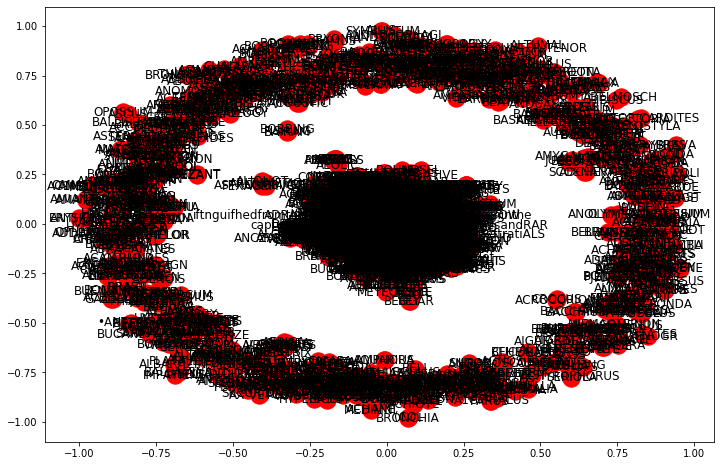

In [152]:
import matplotlib.pyplot as plt
#matplotlib inline

plt.figure(figsize=(12,8))
nx.draw_networkx(graph_df, with_labels=True)

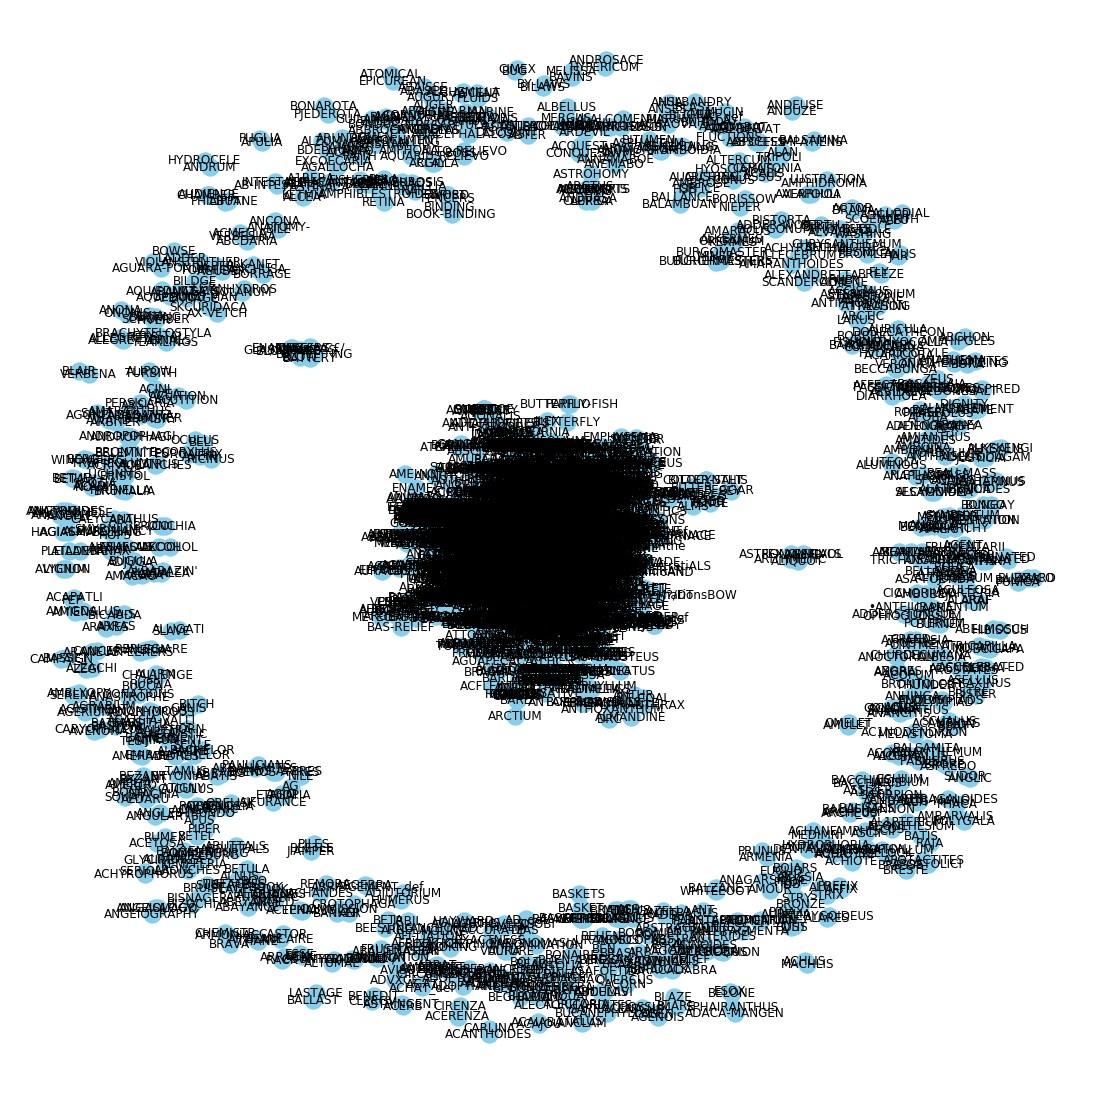

In [153]:
plt.figure(figsize=(15,15))

pos = nx.spring_layout(graph_df)
nx.draw(graph_df, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()